In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Objective

<p> Train a classifier to identify 3 types of women's footwear using fastai library
    
    - Stilettos
    - Boots
    - Sneakers
    
The data will be gathered from image search on google.
    
    

In [2]:
from fastai.vision import *

# Collecting Data

<p> We use Google images to search for the data.

- For each category we issue google image query
- We then collect the url's in a csv file as shown by the fastai lesson2
- We download data for each category and then attempt to remove the data that was not cleanly downloaded

In [3]:
'''
Setup data directory and return its path instance

For each category it will setup a path as follows

'''
def get_data_path(root, categories):
    path = Path(root + '/footwear')
    for category in categories:
        dest = path/category
        dest.mkdir(parents=True, exist_ok=True)
    return path
        

'''
Download data for each category. Delete images not correctly downloaded

Obtain csv containing urls for searched image category by running following
command in JS console of chrome browser
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
'''
def download_data(path, categories, categories_csv):
    for i in range(0,len(categories_csv)):
        download_images(path/categories_csv[i], path/categories[i], max_pics=300)

    for category in categories:
        verify_images(path/category, delete=True, max_size=500)
 

In [4]:
classes = ['boots', 'sneakers', 'stilettos']
root = '/home/ubuntu/fastai/data'
path = get_data_path(root, classes)

In [9]:
categories_csv = ['boots.csv', 'sneakers.csv', 'stilettos.csv']
download_data(path, classes, categories_csv)

In [5]:
path.ls()

[PosixPath('/home/ubuntu/fastai/data/footwear/stilettos.csv'),
 PosixPath('/home/ubuntu/fastai/data/footwear/stilettos'),
 PosixPath('/home/ubuntu/fastai/data/footwear/boots'),
 PosixPath('/home/ubuntu/fastai/data/footwear/sneakers.csv'),
 PosixPath('/home/ubuntu/fastai/data/footwear/sneakers'),
 PosixPath('/home/ubuntu/fastai/data/footwear/models'),
 PosixPath('/home/ubuntu/fastai/data/footwear/boots.csv')]

# Prepare Data Bunch

<p>Use the data directory setup above to prepare the data bunch.  
    
   - We will use the validation split of 0.2,  
   - the imagenet stats for normalization of the pixel values  
   - the standard set of transforms  
   - image size of 224  

In [6]:
np.random.seed(42)
db = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
db.classes

['boots', 'sneakers', 'stilettos']

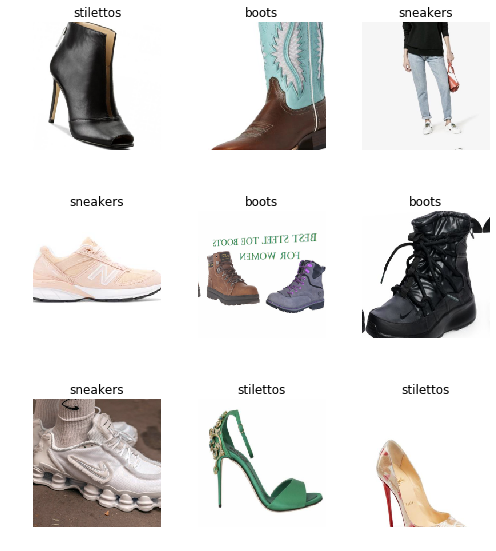

In [8]:
db.show_batch(rows=3, figsize=(7,8))

In [9]:
len(db.train_ds), len(db.valid_ds)

(682, 170)

# Training the model
<p> We use resent34 based model to do the training. First we will only train the fully connected layers and evaluate the performance

In [25]:
learner = cnn_learner(db, models.resnet34, metrics=error_rate)

In [26]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.981020,0.393455,0.117647,00:08
1,0.599032,0.543290,0.247059,00:08
2,0.440712,0.352422,0.129412,00:08
3,0.342876,0.252548,0.076471,00:08


In [27]:
learner.save('stage-1')

We will now attempt to train the rest of the model

In [28]:
learner.unfreeze()

In [29]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


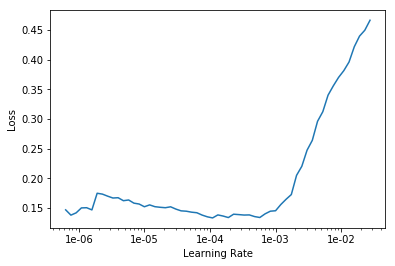

In [30]:
learner.recorder.plot()


In [31]:
learner.fit_one_cycle(4, max_lr=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.243934,1.716210,0.258824,00:09
1,0.311729,2.831776,0.294118,00:09
2,0.331016,1.506881,0.176471,00:10
3,0.294184,0.399789,0.117647,00:09


In [32]:
learner.fit_one_cycle(2, max_lr=slice(None, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.205575,0.239582,0.105882,00:09
1,0.182826,0.216526,0.088235,00:09


In [33]:
learner.fit_one_cycle(3, max_lr=slice(None, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.170928,0.194630,0.094118,00:09
1,0.150435,0.180046,0.076471,00:09
2,0.131264,0.182571,0.076471,00:09


In [34]:
learner.fit_one_cycle(2, max_lr=slice(None, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.096485,0.177099,0.052941,00:10
1,0.086029,0.170828,0.058824,00:10


In [36]:
learner.fit_one_cycle(2, max_lr=slice(None, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.087546,0.170324,0.047059,00:09
1,0.083475,0.169674,0.047059,00:09


In [37]:
learner.save('stage-2')

# Interpretation

We use the stage 1 weights to evaluate the training outcomes.


In [38]:
learner.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (682 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stilettos,stilettos,stilettos,stilettos,stilettos
Path: /home/ubuntu/fastai/data/footwear;

Valid: LabelList (170 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stilettos,boots,stilettos,stilettos,sneakers
Path: /home/ubuntu/fastai/data/footwear;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [39]:
interpreter = ClassificationInterpretation.from_learner(learner)

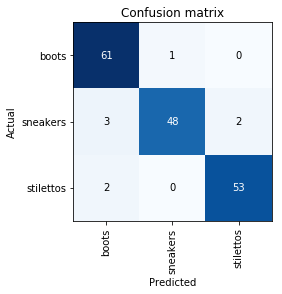

In [40]:
interpreter.plot_confusion_matrix()

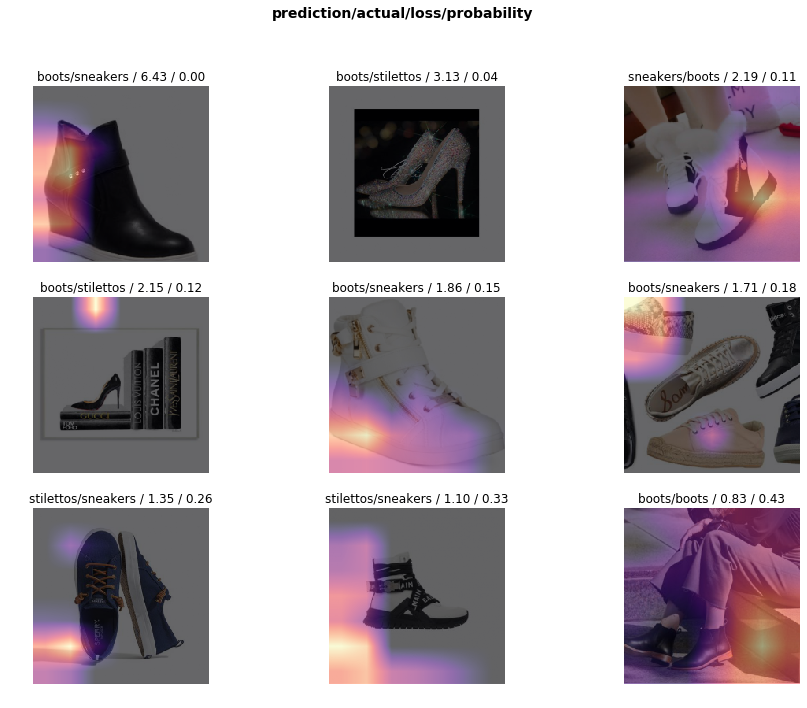

In [41]:
interpreter.plot_top_losses(9, figsize=(15,11))

# Cleaning Data

Some of the images above have lots of noise that can throw off the classification model.
We eliminate some of this data

In [42]:
from fastai.widgets import *

In [43]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )


In [44]:
learner = cnn_learner(db, models.resnet34, metrics=error_rate)
learner.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (852 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stilettos,stilettos,stilettos,stilettos,stilettos
Path: /home/ubuntu/fastai/data/footwear;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/ubuntu/fastai/data/footwear;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(6

In [45]:
doc(DatasetFormatter)

In [46]:
ds, idxs = DatasetFormatter().from_toplosses(learner)

In [47]:
doc(ImageCleaner)

In [48]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

In [49]:
path.ls()


[PosixPath('/home/ubuntu/fastai/data/footwear/stilettos.csv'),
 PosixPath('/home/ubuntu/fastai/data/footwear/stilettos'),
 PosixPath('/home/ubuntu/fastai/data/footwear/boots'),
 PosixPath('/home/ubuntu/fastai/data/footwear/sneakers.csv'),
 PosixPath('/home/ubuntu/fastai/data/footwear/cleaned.csv'),
 PosixPath('/home/ubuntu/fastai/data/footwear/sneakers'),
 PosixPath('/home/ubuntu/fastai/data/footwear/models'),
 PosixPath('/home/ubuntu/fastai/data/footwear/boots.csv')]